In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
file_path3 = '/home/vincent/Documents/Multitel/Projects/TRAIL_workshop_Portugal/project/TRAIL24/dataset_electricity/residential_all.pkl'

In [3]:
#file_path3 = '/kaggle/input/all-data/residential_all.pkl'
df3 = pd.read_pickle(file_path3)
df3["ID"] = df3["ID"].astype("category")
df3["time_code"] = df3["time_code"].astype("uint16")

In [4]:
df3

,ID,consumption,day_code,time_code,date_time
0,1002,0.362,195,1,2009-07-14 00:30:00
1,1002,0.064,195,2,2009-07-14 01:00:00
2,1002,0.119,195,3,2009-07-14 01:30:00
3,1002,0.023,195,4,2009-07-14 02:00:00
4,1002,0.140,195,5,2009-07-14 02:30:00
...,...,...,...,...,...
93624187,7443,0.486,730,44,2010-12-31 22:00:00
93624188,7443,0.318,730,45,2010-12-31 22:30:00
93624189,7443,0.332,730,46,2010-12-31 23:00:00
93624190,7443,0.357,730,47,2010-12-31 23:30:00


In [5]:
def resample_building_data(group):
    group = group.reset_index(level='ID')
    # Specify columns explicitly for summing
    resampled_group = group.resample('h').agg({'consumption': 'sum'})  # Example if 'consumption' is your numeric column
    resampled_group['ID'] = group['ID'].iloc[0]  # Handle non-numeric separately if needed
    resampled_group = resampled_group.set_index('ID', append=True)
    return resampled_group

In [6]:
df3 = df3.set_index(["date_time","ID"])
df3 = df3.groupby('ID', group_keys=False, observed=True).apply(resample_building_data)
df3=df3.reset_index(level=['ID',"date_time"])

In [7]:
df3

,date_time,ID,consumption
0,2009-07-14 00:00:00,1002,0.362
1,2009-07-14 01:00:00,1002,0.183
2,2009-07-14 02:00:00,1002,0.163
3,2009-07-14 03:00:00,1002,0.144
4,2009-07-14 04:00:00,1002,0.139
...,...,...,...
46815730,2010-12-31 20:00:00,7443,1.373
46815731,2010-12-31 21:00:00,7443,1.584
46815732,2010-12-31 22:00:00,7443,0.804
46815733,2010-12-31 23:00:00,7443,0.689


In [8]:
# Generate the range of date_time values
start_time = pd.Timestamp('2009-07-14 00:00:00')
end_time = pd.Timestamp('2011-01-01 00:00:00')
date_range = pd.date_range(start=start_time, end=end_time, freq='h')

# Pivot the dataset
df_pivoted = df3.pivot(index='ID', columns='date_time', values='consumption').reset_index()

# Ensure columns are sorted by date_time
# df_pivoted = df_pivoted.sort_index(axis=1)

# Optional: Rename the columns to make them more readable
df_pivoted.columns.name = None
df_pivoted.columns = ['ID'] + [date.strftime('%Y-%m-%d %H:%M:%S') for date in date_range]

In [9]:
from TRAIL24.data.preprocess import *

In [84]:
df_pivoted.loc[0][1:]

2009-07-14 00:00:00    0.362
2009-07-14 01:00:00    0.183
2009-07-14 02:00:00    0.163
2009-07-14 03:00:00    0.144
2009-07-14 04:00:00    0.139
                       ...  
2010-12-31 20:00:00    0.212
2010-12-31 21:00:00    0.211
2010-12-31 22:00:00    0.200
2010-12-31 23:00:00    0.405
2011-01-01 00:00:00    0.280
Name: 0, Length: 12865, dtype: float64

In [10]:
# Assuming df_pivoted is your pivoted DataFrame with 'ID' as the first column
# Create a list to store the aggregation results
aggregation_results = []

for i, row in df_pivoted.iterrows():
    building_data = row[1:].astype(float)  # Skip the first column (ID)
    building_series = pd.Series(building_data.values, index=pd.date_range(start='2009-07-14 00:00:00', periods=len(building_data), freq='h'))
    
    # Perform the aggregations
    weekday_avg = weekday_average(building_series)
    segment_avg = day_segment_average(building_series)
    total_energy = total_energy_used(building_series)
    avg_energy = average_energy_used(building_series)
    we_bd_avg = weekend_businessday_avg(building_series)
    
    
    # Combine all the aggregation results for the current building
    aggregation_result = np.concatenate([weekday_avg, segment_avg, [total_energy], avg_energy, we_bd_avg])
    aggregation_results.append(aggregation_result)

# Define the columns for the aggregation results
aggregation_columns = [
    'avg_mon', 'avg_tue', 'avg_wed', 'avg_thu', 'avg_fri', 'avg_sat', 'avg_sun',
    'avg_early_morning', 'avg_morning', 'avg_early_afternoon', 'avg_late_afternoon', 'avg_night',
    'total_energy_used',
    'hourly_avg_energy', 'daily_avg_energy', 'weekly_avg_energy', 'monthly_avg_energy',
    'weekend_avg_energy', 'business_day_avg_energy'
]

# Convert the aggregation results to a DataFrame
df_aggregations = pd.DataFrame(aggregation_results, columns=aggregation_columns)
df_aggregations["business_day_avg_energy"] = df_aggregations["avg_mon"]+df_aggregations["avg_tue"]+df_aggregations["avg_wed"]+df_aggregations["avg_thu"]+df_aggregations["avg_fri"]
df_aggregations["weekend_avg_energy"] = df_aggregations["avg_sat"]+df_aggregations["avg_sun"]

# Concatenate the original pivoted dataframe with the aggregations dataframe
df_final = pd.concat([df_pivoted.reset_index(drop=True), df_aggregations], axis=1)

# Display the final dataframe
len(df_final)

3639

In [11]:
df_final

,ID,2009-07-14 00:00:00,2009-07-14 01:00:00,2009-07-14 02:00:00,2009-07-14 03:00:00,2009-07-14 04:00:00,2009-07-14 05:00:00,2009-07-14 06:00:00,2009-07-14 07:00:00,2009-07-14 08:00:00,...,avg_early_afternoon,avg_late_afternoon,avg_night,total_energy_used,hourly_avg_energy,daily_avg_energy,weekly_avg_energy,monthly_avg_energy,weekend_avg_energy,business_day_avg_energy
0,1002,0.362,0.183,0.163,0.144,0.139,0.144,0.186,0.185,0.164,...,1.440979,2.012978,8.731623,5352.685004,0.416066,9.967756,69.515390,281.720263,17.400892,52.478744
1,1003,0.692,0.761,0.725,0.546,0.729,0.755,0.773,0.743,0.911,...,4.689468,8.036418,24.965893,16304.739502,1.267372,30.362643,211.749864,858.144184,61.914071,151.027790
2,1004,1.310,2.360,1.693,1.738,0.833,0.789,0.709,0.756,1.397,...,7.577670,13.974491,44.876255,25324.817494,1.968505,47.159809,328.893734,1332.885131,100.775499,230.033317
3,1005,0.177,0.324,0.317,0.311,0.305,0.304,0.303,0.300,1.213,...,5.513397,7.452884,22.078742,16063.043504,1.248585,29.912558,208.610955,845.423342,63.923032,145.887192
4,1006,0.048,0.183,0.101,0.175,1.062,0.322,0.151,0.241,0.157,...,3.523187,8.517114,17.959478,11518.813505,0.895361,21.450304,149.594981,606.253342,43.190854,107.240723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,7437,0.256,0.523,0.522,0.520,0.520,0.497,0.636,0.714,0.582,...,5.155653,7.861200,19.281137,15395.226502,1.196675,28.668951,199.938007,810.275079,57.534427,143.502237
3635,7438,0.023,0.026,0.025,0.030,0.045,0.025,0.025,0.045,0.029,...,1.217498,1.630035,5.423145,3588.008000,0.278897,6.681579,46.597506,188.842526,14.193767,32.688677
3636,7441,0.289,0.307,0.207,0.208,0.209,0.215,0.212,0.510,0.658,...,3.127761,4.433769,19.589242,10156.315998,0.789453,18.913065,131.900208,534.542947,38.885392,93.754628
3637,7442,0.584,0.403,0.395,0.213,0.184,0.193,0.376,0.405,0.936,...,7.235604,11.595080,32.153855,21951.574017,1.706302,40.878164,285.085377,1155.346001,89.374091,197.343604


In [12]:
df_aggregations

,avg_mon,avg_tue,avg_wed,avg_thu,avg_fri,avg_sat,avg_sun,avg_early_morning,avg_morning,avg_early_afternoon,avg_late_afternoon,avg_night,total_energy_used,hourly_avg_energy,daily_avg_energy,weekly_avg_energy,monthly_avg_energy,weekend_avg_energy,business_day_avg_energy
0,11.027316,10.062649,11.122857,10.578519,9.687403,9.149813,8.251079,0.497269,2.585576,1.440979,2.012978,8.731623,5352.685004,0.416066,9.967756,69.515390,281.720263,17.400892,52.478744
1,31.183842,29.697416,30.156221,30.379247,29.611065,31.538091,30.375980,2.269243,4.317032,4.689468,8.036418,24.965893,16304.739502,1.267372,30.362643,211.749864,858.144184,61.914071,151.027790
2,48.723382,46.760506,47.301818,44.980273,42.267338,48.901611,51.873888,1.855058,5.445479,7.577670,13.974491,44.876255,25324.817494,1.968505,47.159809,328.893734,1332.885131,100.775499,230.033317
3,29.639750,30.498533,30.467156,28.139805,27.141948,29.258288,34.664743,2.624985,5.528319,5.513397,7.452884,22.078742,16063.043504,1.248585,29.912558,208.610955,845.423342,63.923032,145.887192
4,22.186671,21.286896,20.109558,21.097455,22.560143,23.029572,20.161283,0.471170,2.344377,3.523187,8.517114,17.959478,11518.813505,0.895361,21.450304,149.594981,606.253342,43.190854,107.240723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,28.139210,28.818000,28.017364,27.319961,31.207701,25.848250,31.686178,1.707017,5.383515,5.155653,7.861200,19.281137,15395.226502,1.196675,28.668951,199.938007,810.275079,57.534427,143.502237
3635,8.011118,6.630935,5.775831,5.824623,6.446169,6.353780,7.839987,0.302741,1.280929,1.217498,1.630035,5.423145,3588.008000,0.278897,6.681579,46.597506,188.842526,14.193767,32.688677
3636,18.890342,18.719831,18.616312,18.746507,18.781636,19.444182,19.441211,1.605631,2.493229,3.127761,4.433769,19.589242,10156.315998,0.789453,18.913065,131.900208,534.542947,38.885392,93.754628
3637,38.239474,40.762805,41.130494,38.904494,38.306338,46.202762,43.171329,2.656780,7.659263,7.235604,11.595080,32.153855,21951.574017,1.706302,40.878164,285.085377,1155.346001,89.374091,197.343604


In [13]:
from TRAIL24.data.cluster import *

In [14]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_aggregations)

data_scaled

array([[-1.06732918, -1.14121825, -1.04257152, ..., -1.16971188,
        -1.29264947, -1.10667229],
       [ 0.62119204,  0.51213192,  0.5639592 , ...,  0.54378058,
         0.46931651,  0.57066845],
       [ 2.09048711,  1.94893354,  2.01115108, ...,  1.95500764,
         2.00756911,  1.91537135],
       ...,
       [-0.40863995, -0.41223819, -0.41007875, ..., -0.41816471,
        -0.44222809, -0.40414168],
       [ 1.21224546,  1.44389568,  1.49025404, ...,  1.42725029,
         1.55626695,  1.35898051],
       [-1.3215769 , -1.30563389, -1.20726633, ..., -1.26606578,
        -1.19777796, -1.28373494]])

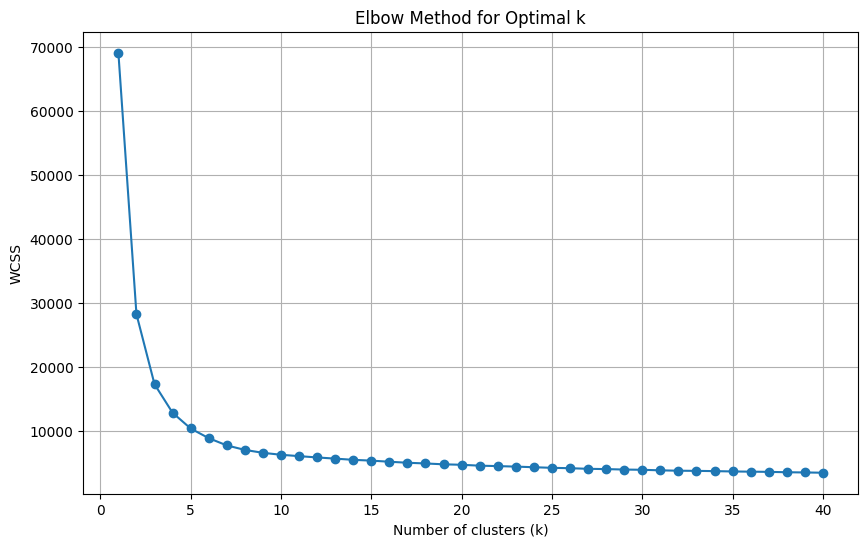

Best k according to elbow method: 3
Silhouette score for the KMeans model is  0.45490023722718975
Davies-Bouldin score for the KMeans model is  0.7454375486927972


In [15]:
# Apply PCA transformation
#pca = PCA(n_components=5)  # Keep 95% of the variance
#data_pca = pca.fit_transform(data_scaled)
#explained_variance_ratio = pca.explained_variance_ratio_
#print(explained_variance_ratio)

# Set the maximum number of clusters to test
max_k = 40

# Calculate and plot elbow method
wcss = calculate_wcss(data_scaled, max_k)
plot_elbow_method(wcss, max_k)

best_k_elbow = 3
print(f'Best k according to elbow method: {best_k_elbow}')

# Apply KMeans clustering
final_kmeans = KMeans(n_clusters=best_k_elbow, random_state=42, n_init=90)
final_kmeans.fit(data_scaled)
labels = final_kmeans.labels_

# Calculate silhouette score
silhouette = silhouette_score(data_scaled, labels)
print("Silhouette score for the KMeans model is ", silhouette)

# Calculate Davies-Bouldin score
dbs = davies_bouldin_score(data_scaled, labels)
print("Davies-Bouldin score for the KMeans model is ", dbs)


In [16]:
from sklearn.manifold import TSNE

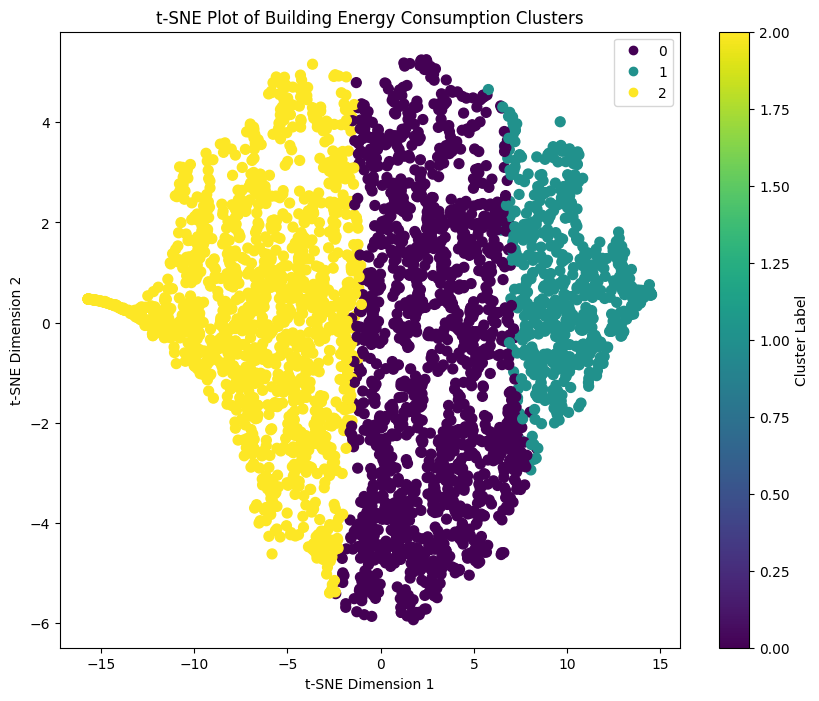

In [17]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(data_scaled)

# Create a DataFrame with t-SNE results and cluster labels
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Cluster': labels
})

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Cluster'], cmap='viridis', s=50)
plt.title('t-SNE Plot of Building Energy Consumption Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
plt.colorbar(scatter, label='Cluster Label')
plt.show()

### Define functions that compute new features

In [18]:
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Compute mean, standard deviation, skewness, kurtosis, periodicity, and energy for a given data series
def compute_statistics(data):
    avg = data.mean()
    std = data.std()
    skw = skew(data)
    krt = kurtosis(data)
    
    # Compute energy (sum of squared values)
    energy = np.sum(data**2)
    
    # Compute periodicity using the dominant frequency from the Fourier Transform
    fft_values = fft(np.array(data))
    fft_magnitudes = np.abs(fft_values)
    periodicity = np.argmax(fft_magnitudes[1:len(fft_magnitudes)//2]) + 1  # Dominant frequency index
    
     # Trend (using linear regression)
    trend = np.polyfit(np.arange(len(data)), data, 1)[0]  # Slope of the trend

    # Seasonality (using Fourier Transform)
    seasonality = fft_magnitudes[1:len(fft_magnitudes)//2].max()  # Magnitude of the dominant frequency

    # Stationarity (using Augmented Dickey-Fuller test)
    adf_result = adfuller(data)
    stationarity = adf_result[0]  # ADF statistic (more negative means more likely stationary)

    # Autocorrelation (first lag)
    autocorr = acf(data, nlags=1)[1]  # ACF for the first lag

    # Partial Autocorrelation (first lag)
    partial_autocorr = pacf(data, nlags=1)[1]  # PACF for the first lag
    
    
    return avg, std, skw, krt, energy, periodicity, trend, seasonality, stationarity, autocorr, partial_autocorr


def weekly_monthly_statistics(data: pd.Series) -> np.ndarray:
    "Compute some statistics (mean, std, skewness, kurtosis, energy, periodicity)"
    
    avgs, stds, skws, krts, energies, periodicities, trends, seasonalities, stationarities, autocorrs, partial_autocorrs = [], [], [], [], [], [], [], [], [], [], []
    
    weeklength = 168*4  # Weekly data length (assuming hourly data)
    
    for i in np.arange(0, len(data)-weeklength, weeklength):
        avg, std, skw, krt, energy, periodicity, trend, seasonality, stationarity, autocorr, partial_autocorr = compute_statistics(data[i:i+weeklength])
        
        avgs.append(avg)
        stds.append(std)
        skws.append(skw)
        krts.append(krt)
        energies.append(energy)
        periodicities.append(periodicity)
        trends.append(trend)
        seasonalities.append(seasonality)
        stationarities.append(stationarity)
        autocorrs.append(autocorrs)
        partial_autocorrs.append(partial_autocorr)
        
    # Combine the statistics into a single array
    weekly_stats = np.concatenate([avgs, stds, skws, krts, energies, periodicities, 
                                   trends, seasonalities, stationarities, autocorrs, partial_autocorrs])
    
    return weekly_stats



### Define functions that aggregate monthly (or weekly) features over time

In [19]:
aggregation_results = []

for i, row in tqdm(df_pivoted.iterrows()):
    building_data = row[1:].astype(float)  # Skip the first column (ID)
    building_series = pd.Series(building_data.values, index=pd.date_range(start='2009-07-14 00:00:00', periods=len(building_data), freq='h'))
    
    # Perform the aggregations
    #stats = weekly_monthly_statistics(building_series)
    
    stats = np.concatenate([compute_statistics(building_series)])
    
    # Combine all the aggregation results for the current building
    aggregation_results.append(stats)
    
    
# Convert the aggregation results to a DataFrame
df_aggregations = pd.DataFrame(aggregation_results)#, columns=aggregation_columns)


3639it [20:26,  2.97it/s]


In [20]:
df_aggregations

,0,1,2,3,4,5,6,7,8,9,10
0,0.416066,0.487727,4.847685,38.710649,5287.121702,1072.0,-0.000002,1482.606030,-15.618198,0.605981,0.606028
1,1.267372,0.854323,2.092084,6.755341,30053.193761,536.0,-0.000013,3005.716434,-12.375761,0.493171,0.493209
2,1.968505,1.719509,2.021788,5.383929,87887.145648,536.0,0.000002,8512.433745,-16.467926,0.551635,0.551678
3,1.248585,1.140870,2.060300,5.334704,36799.641483,536.0,0.000017,3540.898170,-9.585958,0.586668,0.586714
4,0.895361,1.192529,2.525526,7.626883,28607.715622,536.0,0.000014,5597.146218,-8.424607,0.662373,0.662424
...,...,...,...,...,...,...,...,...,...,...,...
3634,1.196675,1.027983,2.592358,8.855069,32017.117934,536.0,0.000069,3345.450958,-10.905020,0.558711,0.558755
3635,0.278897,0.755897,3.925795,17.381851,8350.916034,10.0,-0.000033,1645.453983,-6.783136,0.759096,0.759155
3636,0.789453,0.563866,0.960262,0.716230,12107.982711,536.0,-0.000005,2683.937303,-8.173058,0.654958,0.655009
3637,1.706302,1.834093,1.934118,4.637357,80729.177648,536.0,-0.000017,6866.127661,-17.675751,0.510434,0.510474


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_autocorrelation_matrix(stats: np.ndarray) -> np.ndarray:
    """
    Compute the autocorrelation matrix for the given statistics.

    Args:
    stats: np.ndarray : Array of computed statistics.

    Returns:
    np.ndarray: Autocorrelation matrix.
    """
    # Ensure the input is a 2D array (weeks x statistics)
    if stats.ndim == 1:
        stats = stats.reshape(-1, 1)

    # Compute the autocorrelation matrix
    autocorr_matrix = np.corrcoef(stats, rowvar=False)
    
    return autocorr_matrix

def plot_autocorrelation_matrix(autocorr_matrix: np.ndarray, labels: list):
    """
    Plot the autocorrelation matrix using seaborn.

    Args:
    autocorr_matrix: np.ndarray : Autocorrelation matrix.
    labels: list : List of labels for the statistics.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(autocorr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=labels, yticklabels=labels)
    plt.title("Autocorrelation Matrix")
    plt.show()

# Example usage:
# Assuming you have a pandas Series `data` with your time series data
# and you have computed `weekly_stats` using the weekly_monthly_statistics function.

# Compute weekly statistics
weekly_stats = weekly_monthly_statistics(building_series)  # This will be a 1D array of all stats

# Reshape weekly_stats to a 2D array (weeks x statistics) if necessary
num_weeks = len(weekly_stats) // 8  # Assuming 6 statistics are computed
weekly_stats_reshaped = weekly_stats.reshape(num_weeks, -1)

# Compute the autocorrelation matrix
autocorr_matrix = compute_autocorrelation_matrix(weekly_stats_reshaped)

# Define labels for the statistics
labels_plots = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'Energy', 'Periodicity', 'Trend', 'Seasonality']

# Plot the autocorrelation matrix
plot_autocorrelation_matrix(autocorr_matrix, labels_plots)

KeyboardInterrupt: 

### Compute DBi as a function of the number of clusters

In [61]:
def calculate_DB_index(data: list[float], # the input dataframe
                       max_k: int # the number of clusters
                      ) -> float:
    "compute the Davies-Bouldin index"
    dbi = []
    for k in range(2, max_k + 1):
        
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        
        #kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        #kmeans.fit(data)
        #labels = kmeans.labels_
        
        spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        labels = spectral.fit_predict(data)
        
        dbi.append(silhouette_score(data, labels))
        
    return dbi


def plot_dbi_versus_Nclusters(dbi:list[float], # the wcss metric to plot
                              max_k:int # the number of clusters
                             ):
    "plot the graph of the dbi as a function of the number of clusters"
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), dbi, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin index')
    plt.grid(True)
    plt.show()

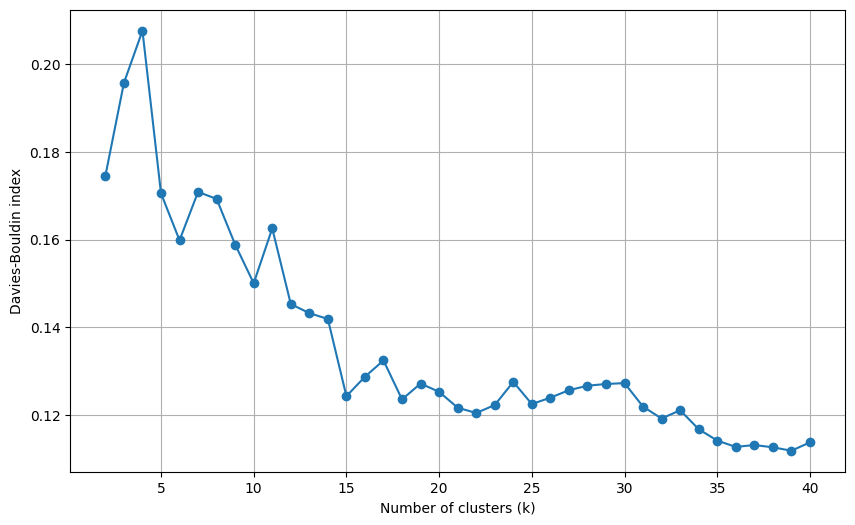

In [62]:
max_k = 40

dbi = calculate_DB_index(df_aggregations, max_k)
plot_dbi_versus_Nclusters(dbi, max_k)

### Study how the clustering method impacts the t-SNE and UMAP plots

In [37]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_aggregations.fillna(0))

# Apply KMeans clustering
final_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
final_kmeans.fit(data_scaled)
labels = final_kmeans.labels_

In [55]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(data_scaled)

### Apply t-SNE to check the cluster behavior

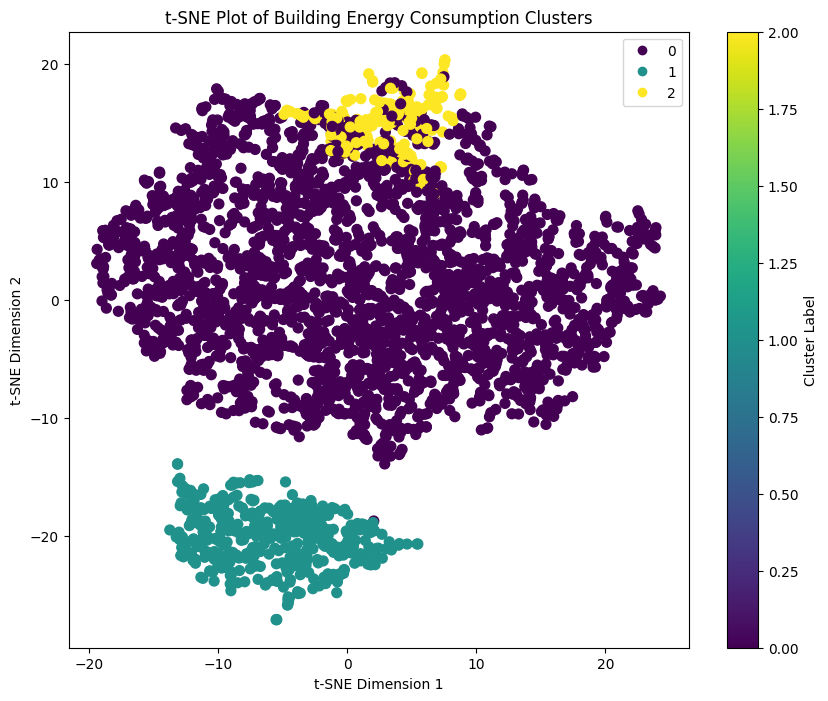

<Figure size 1500x1500 with 0 Axes>

In [56]:
# Apply t-SNE
tsne = TSNE(n_components=3, perplexity=20, learning_rate=500 , n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(data_scaled)

# Create a DataFrame with t-SNE results and cluster labels
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    't-SNE3': tsne_results[:, 2],
    'Cluster': labels
})

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Cluster'], cmap='viridis', s=50)
plt.title('t-SNE Plot of Building Energy Consumption Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
plt.colorbar(scatter, label='Cluster Label')
plt.show()


import plotly.express as px

# Plotting with Plotly
plt.figure(figsize=(15,15))
fig = px.scatter_3d(tsne_df, x='t-SNE1', y='t-SNE2', z='t-SNE3', color='Cluster',
                    labels={'t-SNE1': 't-SNE Dimension 1', 't-SNE2': 't-SNE Dimension 2', 't-SNE3': 't-SNE Dimension 3'},
                    color_continuous_scale='Viridis')
fig.show()

In [57]:
import umap

/home/vincent/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/vincent/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



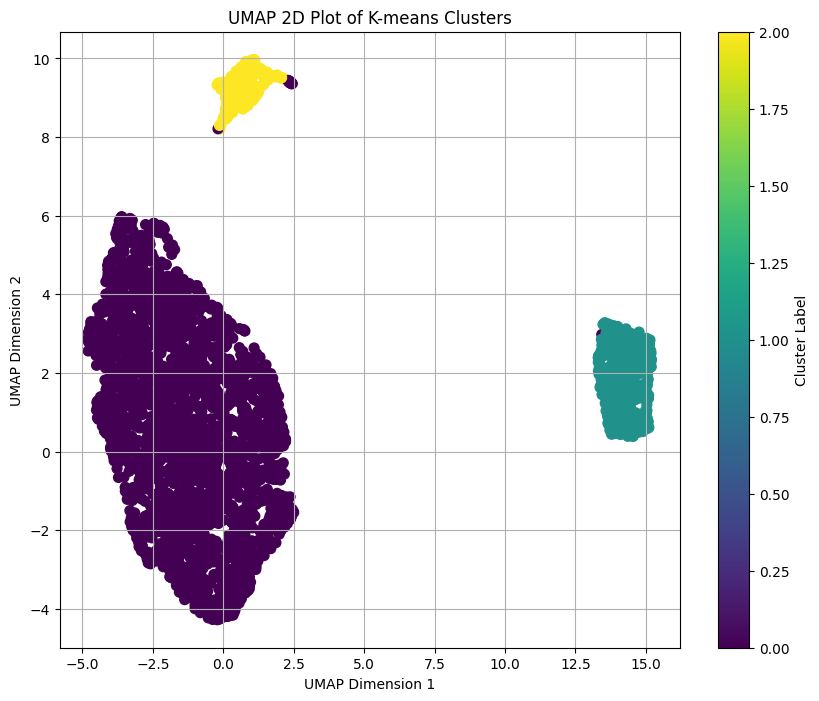

In [98]:
# Apply UMAP for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_results_2d = umap_2d.fit_transform(data_scaled)

# Apply UMAP for 3D visualization
umap_3d = umap.UMAP(n_components=3, random_state=42)
umap_results_3d = umap_3d.fit_transform(data_scaled)

# Create DataFrames with UMAP results and K-means cluster labels
umap_df_2d = pd.DataFrame({
    'UMAP1': umap_results_2d[:, 0],
    'UMAP2': umap_results_2d[:, 1],
    'Cluster': labels
})

umap_df_3d = pd.DataFrame({
    'UMAP1': umap_results_3d[:, 0],
    'UMAP2': umap_results_3d[:, 1],
    'UMAP3': umap_results_3d[:, 2],
    'Cluster': labels
})

# 2D Plotting with Matplotlib
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_df_2d['UMAP1'], umap_df_2d['UMAP2'], c=umap_df_2d['Cluster'], cmap='viridis', s=50)
plt.title('UMAP 2D Plot of K-means Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

# 3D Plotting with Plotly
fig = px.scatter_3d(umap_df_3d, x='UMAP1', y='UMAP2', z='UMAP3', color='Cluster',
                    title='UMAP 3D Plot of K-means Clusters',
                    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2', 'UMAP3': 'UMAP Dimension 3'},
                    color_continuous_scale='Viridis')
fig.show()

In [67]:
def revert_umap_projection_2D(umap_value_1, umap_value_2):
    
    # Example: Find the original row corresponding to a specific UMAP projection
    # Let's say you're looking for the closest point to [UMAP1_value, UMAP2_value]
    UMAP1_value = umap_value_1
    UMAP2_value = umap_value_2

    # Calculate the Euclidean distance between the given UMAP values and all UMAP projections
    distances = np.sqrt((umap_df_2d['UMAP1'] - UMAP1_value)**2 + (umap_df_2d['UMAP2'] - UMAP2_value)**2)

    # Find the index of the minimum distance
    min_distance_index = distances.idxmin()

    return min_distance_index


def revert_umap_projection_3D(umap_value_1, umap_value_2, umap_value_3):
    
    # Example: Find the original row corresponding to a specific UMAP projection
    # Let's say you're looking for the closest point to [UMAP1_value, UMAP2_value]
    UMAP1_value = umap_value_1
    UMAP2_value = umap_value_2
    UMAP3_value = umap_value_3

    # Calculate the Euclidean distance between the given UMAP values and all UMAP projections
    distances = np.sqrt(
                            (umap_df_3d['UMAP1'] - UMAP1_value)**2 + 
                            (umap_df_3d['UMAP2'] - UMAP2_value)**2 + 
                            (umap_df_3d['UMAP3'] - UMAP3_value)**2
                        )

    # Find the index of the minimum distance
    min_distance_index = distances.idxmin()

    return min_distance_index


### Plot the timeseries in the clusters

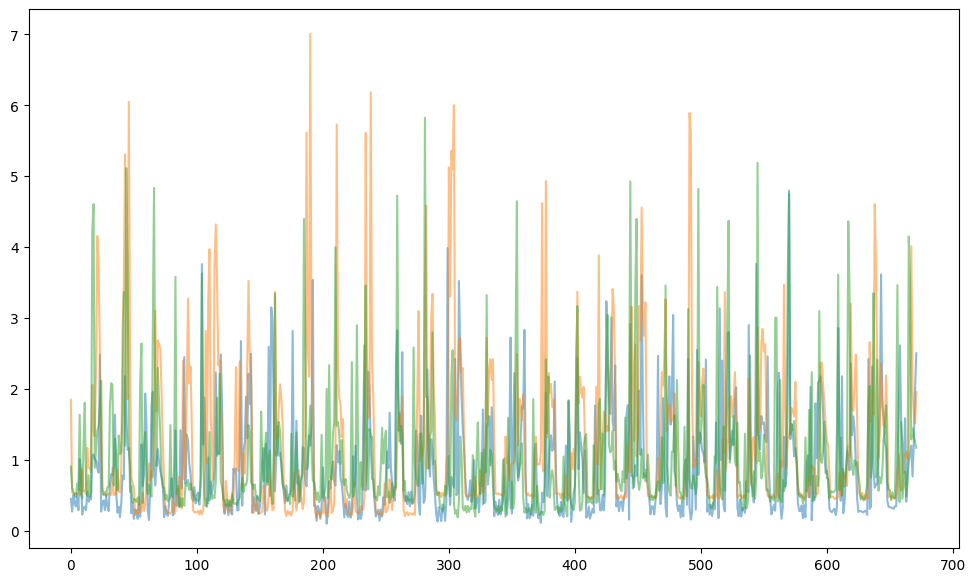

In [104]:
# Purple cluster

start = 10
start_week = 168*10
weeklength = 168*4

plt.figure(figsize=(12,7))
plt.plot(df_pivoted.loc[revert_umap_projection_2D(0.0, 0.0)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(df_pivoted.loc[revert_umap_projection_2D(-2.5, 2.0)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(df_pivoted.loc[revert_umap_projection_2D(-2.5, -2.0)][1+start_week:start_week+weeklength+1].values, alpha=0.5)

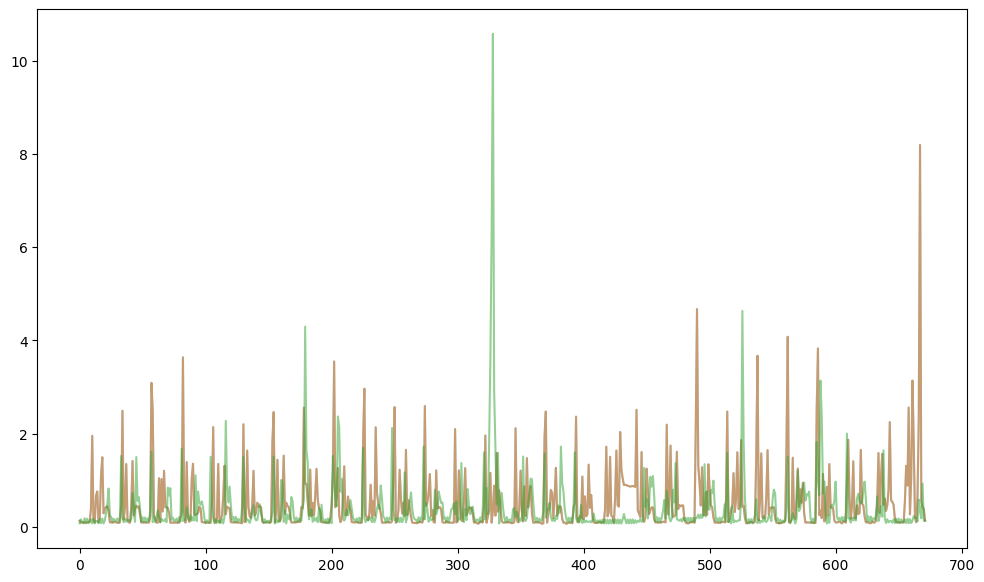

In [103]:
# Blue cluster

start = 10
start_week = 168*10
weeklength = 168*4

plt.figure(figsize=(12,7))
plt.plot(df_pivoted.loc[revert_umap_projection_2D(3.0, 14.0)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(df_pivoted.loc[revert_umap_projection_2D(2.0, 15.0)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(df_pivoted.loc[revert_umap_projection_2D(1.0, 13.5)][1+start_week:start_week+weeklength+1].values, alpha=0.5)

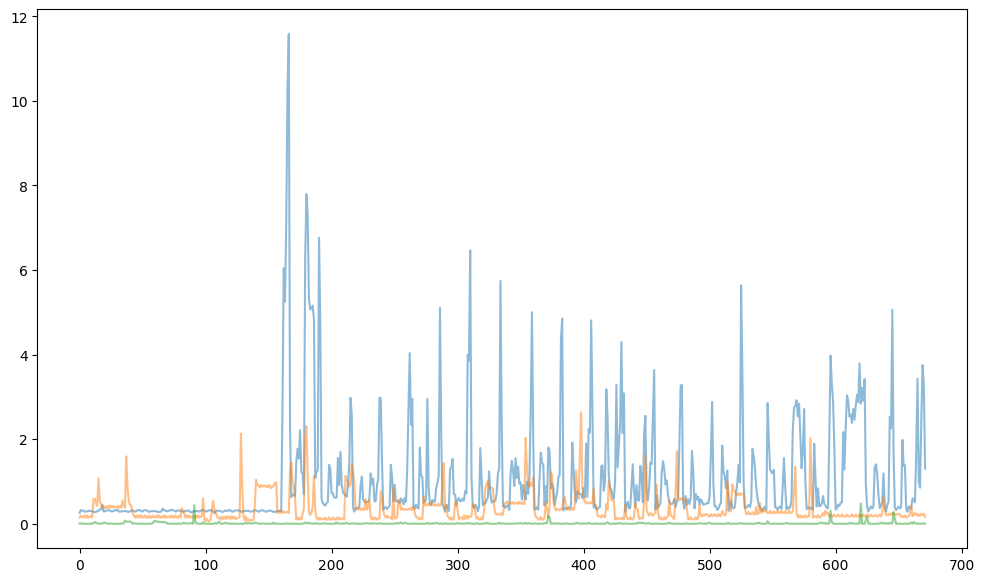

In [102]:
# Yellow cluster

start = 10
start_week = 168*10
weeklength = 168*4

plt.figure(figsize=(12,7))
plt.plot(df_pivoted.loc[revert_umap_projection_2D(0.0, 9.0)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(df_pivoted.loc[revert_umap_projection_2D(1.0, 9.5)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(df_pivoted.loc[revert_umap_projection_2D(1.25, 8.75)][1+start_week:start_week+weeklength+1].values, alpha=0.5)

### Get the indexes of each cluster

In [106]:
umap_df_2d = pd.DataFrame({
    'UMAP1': umap_results_2d[:, 0],
    'UMAP2': umap_results_2d[:, 1],
    'Cluster': labels
})


cluster_0 = []
cluster_1 = []
cluster_2 = []


for i,j,k in tqdm(zip(umap_results_2d[:,0], umap_results_2d[:,1], labels)):
    
    index = revert_umap_projection_2D(i, j)
    
    if(k==0):
        cluster_0.append(index)
        
    elif(k==1):
        cluster_1.append(index)
        
    else:
        cluster_2.append(index)


3639it [00:00, 5102.84it/s]


In [110]:
print(len(cluster_0), len(cluster_1), len(cluster_2))

2973 457 209


In [111]:

np.save('/home/vincent/Documents/Multitel/Projects/TRAIL_workshop_Portugal/project/TRAIL24/centralized experiments/cluster_0.npy', 
        np.array(cluster_0))

np.save('/home/vincent/Documents/Multitel/Projects/TRAIL_workshop_Portugal/project/TRAIL24/centralized experiments/cluster_1.npy', 
        np.array(cluster_1))

np.save('/home/vincent/Documents/Multitel/Projects/TRAIL_workshop_Portugal/project/TRAIL24/centralized experiments/cluster_2.npy', 
        np.array(cluster_2))

